# Parameter evaluation

The goal of this notebook is to decide on the best parameters for our TDA. This follows the two heuristics in Chang et al. 

Parameters are used for the clustering algorithm and the Mapper algorithm. We try out different clustering algorithms, parameters for the clustering algorithm, and parameters for the clustering algorithm.

COND is removed in this analysis.

## Load libraries

In [210]:
import kmapper as km
# import sklearn

from sklearn.cluster import DBSCAN # clustering algorithm
from sklearn.decomposition import PCA # projection (lens) creation

# from sklearn import ensemble
# from sklearn.manifold import MDS

import plotly.graph_objs as go
# from ipywidgets import interactive, HBox, VBox, widgets, interact # ?
# import dash_html_components as html # ?
# import dash_core_components as dcc # ?

from kmapper.plotlyviz import * # static and interactive plots
import psutil # for plotlyviz
import kaleido # for plotlyviz
# import networkx # ?

# import dash # ?
import warnings #? 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read data

In [2]:
water20 = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")

In [3]:
water20.head()

,SHEETBAR,DATE,LATITUDE,LONGITUDE,FLDNUM,STRATUM,LOCATCD,TN,TP,TEMP,DO,TURB,COND,VEL,SS,WDP,CHLcal,SECCHI,YEAR,SEASON
0,41000065,07/26/1993,44.571864,-92.510970,"Lake City, MN",Main channel,9312103,3.955,0.228,23.0,6.6,28,550.0,0.50,42.3,2.2,9.44875,40,1993,2
1,41000066,07/26/1993,44.575497,-92.518497,"Lake City, MN",Main channel,9312002,4.876,0.229,23.0,6.6,28,554.0,0.72,37.6,8.2,8.24230,42,1993,2
2,41000067,07/26/1993,44.573718,-92.523549,"Lake City, MN",Main channel,9312102,3.955,0.220,22.9,6.3,24,564.0,0.66,34.1,4.3,8.72488,43,1993,2
3,41000068,07/26/1993,44.566588,-92.541238,"Lake City, MN",Main channel,9312003,4.257,0.212,22.9,6.4,28,563.0,0.69,33.4,9.1,8.48359,38,1993,2
4,41000069,07/26/1993,44.568419,-92.548780,"Lake City, MN",Main channel,9312104,4.030,0.237,23.0,6.6,33,556.0,0.68,48.0,6.7,9.52918,45,1993,2


## Define functions

In [14]:
def cluster_fun(df, DBSCAN_EPSILON = 10, DBSCAN_MIN_SAMPLES = 20, 
                N_CUBES = [10,10], PERC_OVERLAP = [.25,.25],
                remove_cond_bool = False):
    """
    
    """

    # title = df["TITLE"].iloc[0]
    
    if remove_cond_bool:
        
        X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                "VEL", "TP", "TN", "SS", "CHLcal"]]
        
    else:
        
        X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                "VEL", "TP", "TN", "SS", "CHLcal", "COND"]]
    
    # used when we had subsets 
    
#     if X.shape[0] < DBSCAN_MIN_SAMPLES:
#         #print(X)
#         print("Not enough data to cluster in ", title, "_size = ", X.shape[0])
#         print("DBSCAN_MIN_SAMPLES", DBSCAN_MIN_SAMPLES)
#         return([DBSCAN_MIN_SAMPLES, X.shape[0]])
    
    db = DBSCAN(eps = DBSCAN_EPSILON, min_samples = DBSCAN_MIN_SAMPLES).fit(X)
    # Number of clusters in labels, ignoring noise if present.
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

#     print('For the ' + title + 'subset, we have:')
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    return(db)

In [16]:
cluster_fun(water20, 10, 20, True)
cluster_fun(water20, 10, 10, True)
# cluster_fun(water20, 10, 20, False)

Estimated number of clusters: 12
Estimated number of noise points: 9199
Estimated number of clusters: 31
Estimated number of noise points: 6573


DBSCAN(eps=10, min_samples=10)

In [109]:
def mapper_pca2_db(df, DBSCAN_EPSILON = 10, DBSCAN_MIN_SAMPLES = 20, 
                N_CUBES = [10,10], PERC_OVERLAP = [.25,.25],
                remove_cond_bool = False, scomplex_bool = False):
    """
    """
    
    if remove_cond_bool:
        
        X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                "VEL", "TP", "TN", "SS", "CHLcal"]]
        
    else:
        
        X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                "VEL", "TP", "TN", "SS", "CHLcal", "COND"]]
    
    # for discerning primary variables in PCA 
    continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                            "VEL", "TP", "TN", "SS", "CHLcal"]
    
    if not remove_cond_bool:
        
        continuous_variables.append("COND")
    
    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in projected_vars]
    
#     if X.shape[0]<10:
#         #print(X)
#         print("Not enough data in ", title, "_size = ", X.shape[0])
#         return(X.shape[0])
    
    # to match up indices in scomplex with the original dataframe X
    X.reset_index(drop = True, inplace = True) 
    
    # create instance of clustering alg
    cluster_alg = DBSCAN(eps = DBSCAN_EPSILON, min_samples = DBSCAN_MIN_SAMPLES, 
                         metric='euclidean')

    # instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)
    
    for j in range(2):
        pc_j = pca.components_[j]
        largest_magnitude = max(abs(pc_j))
        idx_magnitude = np.where(abs(pc_j) == largest_magnitude)[0][0]
        
        print("*** PCA", j+1, " ***")
        print("Primary variable: ", continuous_variables[idx_magnitude])
        print("Corresponding component: ", pc_j[idx_magnitude])
        print("Explained variance: ", pca.explained_variance_ratio_[j])
    
    summary_variable = mapper.project(np.array(X), projection=projected_var_indices, scaler=None)
    # similar to fit transform
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, 
                          cover=km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                          clusterer = cluster_alg)  

    if scomplex_bool: 
        return(scomplex)
    
    # the rest of this is for coloring 
    
    pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

    color_values = lens[:,0] - lens[:,0].min() # changes if PCA1 or PCA1 and PCA2
    # can change to other variables
    color_function_name = ['Distance to x-min'] # set name of color function
    my_colorscale = pl_brewer
    kmgraph, mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                    color_values,
                                                                    color_function_name=color_function_name, 
                                                                    colorscale=my_colorscale)
    
    plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                     factor_size=2.5, edge_linewidth=0.5)
    
    plot_title = str(DBSCAN_EPSILON) + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 

    layout = plot_layout(title=plot_title,  
                         width=620, height=570,
                         annotation_text=get_kmgraph_meta(mapper_summary))

    # FigureWidget is responsible for event listeners

    fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
    fw_summary = summary_fig(mapper_summary, height=300)

    dashboard = hovering_widgets(kmgraph, fw_graph, member_textbox_width=600)

    # DESIRED FILE PATH, CHANGE TO FIT YOUR LOCAL MACHINE
    directory_path = "mapper outputs"
    
    #Update the fw_graph colorbar, setting its title:
    fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'
    html_output_path = directory_path + 'Eps_' + str(DBSCAN_EPSILON) +'_MinS_' + str(DBSCAN_MIN_SAMPLES) + '_NCubes_' + str(N_CUBES) + '_PercOvlp_' + str(PERC_OVERLAP) + '.html'
    mapper.visualize(scomplex, color_values=color_values, color_function_name=color_function_name,
                     path_html=html_output_path, lens = summary_variable, lens_names = projected_vars)
    
    return scomplex, X

In [107]:
def mapper_pca2_hdb(df, HDB_MIN_CLUSTER = 45, HDB_MIN_SAMP = 10, 
                N_CUBES = [10,10], PERC_OVERLAP = [.25,.25],
                remove_cond_bool = False, scomplex_bool = False):
    """
    """
    
    if remove_cond_bool:
        
        X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                "VEL", "TP", "TN", "SS", "CHLcal"]]
        
    else:
        
        X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                "VEL", "TP", "TN", "SS", "CHLcal", "COND"]]
    
    # for discerning primary variables in PCA 
    continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", 
                            "VEL", "TP", "TN", "SS", "CHLcal"]
    
    if not remove_cond_bool:
        
        continuous_variables.append("COND")
    
    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in projected_vars]
    
#     if X.shape[0]<10:
#         #print(X)
#         print("Not enough data in ", title, "_size = ", X.shape[0])
#         return(X.shape[0])
    
    # to match up indices in scomplex with the original dataframe X
    X.reset_index(drop = True, inplace = True) 
    
    # create instance of clustering alg
    cluster_alg = hdbscan.HDBSCAN(min_cluster_size = HDB_MIN_CLUSTER, min_samples = HDB_MIN_SAMP)

    # instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)
    
    for j in range(2):
        pc_j = pca.components_[j]
        largest_magnitude = max(abs(pc_j))
        idx_magnitude = np.where(abs(pc_j) == largest_magnitude)[0][0]
        
        print("*** PCA", j+1, " ***")
        print("Primary variable: ", continuous_variables[idx_magnitude])
        print("Corresponding component: ", pc_j[idx_magnitude])
        print("Explained variance: ", pca.explained_variance_ratio_[j])
    
    summary_variable = mapper.project(np.array(X), projection=projected_var_indices, scaler=None)
    # similar to fit transform
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, 
                          cover=km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                          clusterer = cluster_alg)  

    if scomplex_bool: 
        return(scomplex)

## Working with a 25% subset of the data

In [8]:
watershort = water20.sample(frac = 0.25)
watershort.shape

(19167, 20)

In [27]:
# X = watershort[["WDP", "SECCHI", "TEMP", "DO", "TURB", 
#                 "VEL", "TP", "TN", "SS", "CHLcal"]]

X = water20[["WDP", "SECCHI", "TEMP", "DO", "TURB",
             "VEL", "TP", "TN", "SS", "CHLcal"]]

# n_data = watershort.shape[0]
n_data = water20.shape[0]

## Clustering algorithms

1. DBscan
2. HDBscan
3. Single linkage

In [149]:
eps_lst = np.linspace(5, 12.5, 4)
min_samp_lst = np.linspace(5, 15, 3)
print(eps_lst[2:3])
print(min_samp_lst)

[10.]
[ 5. 10. 15.]


#### DBscan

In [48]:
for epsilon in eps_lst[2:3]:
    
    for min_samp in min_samp_lst:
        
        db = DBSCAN(epsilon, min_samp).fit(X)
        
    # Number of clusters in labels, ignoring noise if present.
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        perc_noise_ = list(labels).count(-1)/n_data

        print('For epsilon = ' + str(epsilon) + ' and min_samp = ' + str(min_samp) + ', we have:')
        print('Estimated number of clusters: %d' % n_clusters_) # %d means double
        print('Estimated percent of noise points: %f' % perc_noise_) # %f means float

For epsilon = 5.0 and min_samp = 5.0, we have:
Estimated number of clusters: 382
Estimated percent of noise points: 0.349255
For epsilon = 5.0 and min_samp = 10.0, we have:
Estimated number of clusters: 131
Estimated percent of noise points: 0.483846
For epsilon = 5.0 and min_samp = 15.0, we have:
Estimated number of clusters: 59
Estimated percent of noise points: 0.570830
For epsilon = 7.5 and min_samp = 5.0, we have:
Estimated number of clusters: 171
Estimated percent of noise points: 0.121379
For epsilon = 7.5 and min_samp = 10.0, we have:
Estimated number of clusters: 47
Estimated percent of noise points: 0.169521
For epsilon = 7.5 and min_samp = 15.0, we have:
Estimated number of clusters: 27
Estimated percent of noise points: 0.205937
For epsilon = 10.0 and min_samp = 5.0, we have:
Estimated number of clusters: 83
Estimated percent of noise points: 0.059190
For epsilon = 10.0 and min_samp = 10.0, we have:
Estimated number of clusters: 31
Estimated percent of noise points: 0.08573

#### HDBscan

https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#selecting-min-cluster-size

In [51]:
import hdbscan

In [156]:
min_cluster_lst = np.linspace(10, 80, 3)
print(min_cluster_lst[0:1])
print(min_samp_lst)

[10.]
[ 5. 10.]


In [157]:
for min_clust in min_cluster_lst[0:1]:
    
    min_clust = int(min_clust)
    
    for min_samp in min_samp_lst:

        min_samp = int(min_samp)

        hdb = hdbscan.HDBSCAN(min_cluster_size = min_clust, min_samples = min_samp).fit(X)

    # Number of clusters in labels, ignoring noise if present.
        labels = hdb.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        perc_noise_ = list(labels).count(-1)/n_data

        print('For min_cluster_size = ' + str(min_clust) + ' and min_samp = ' + str(min_samp) + ', we have:')
        print('Estimated number of clusters: %d' % n_clusters_) # %d means double
        print('Estimated percent of noise points: %f' % perc_noise_) # %f means float

For min_cluster_size = 10 and min_samp = 5, we have:
Estimated number of clusters: 5
Estimated percent of noise points: 0.004826
For min_cluster_size = 10 and min_samp = 10, we have:
Estimated number of clusters: 3
Estimated percent of noise points: 0.001278
For min_cluster_size = 10 and min_samp = 15, we have:
Estimated number of clusters: 2
Estimated percent of noise points: 0.001122


#### Single linkage clustering algorithm

It seems like DBscan and HDBscan are the best. Algomerative clustering doesn't give the chance for noise and requires us to name the number of eventual clusters. Referring back to here: https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

## PCA2 projection

In [220]:
pca = PCA(n_components = 2)
lens = pca.fit_transform(X)

lens[:,0]

array([-12.88764137, -16.91707909, -22.24078733, ..., -10.48235291,
        -4.32391009,  -9.72842146])

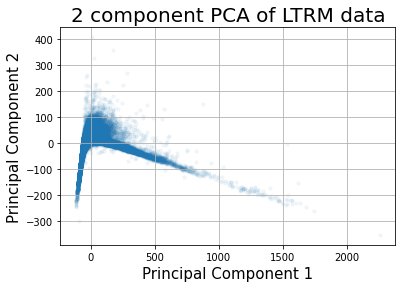

In [242]:
fig, ax = plt.subplots()
ax.scatter(lens[:,0], lens[:,1], s = 10, alpha = 0.047)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA of LTRM data', fontsize = 20)
ax.grid(True)

plt.show()

## Incorporating the clustering algorithms with km

In [146]:
n_cubes_lst = []

for n in [25, 50, 75, 100]:
    n_cubes_lst.append([n, n])

perc_overlap_lst = []

for perc in np.linspace(0.20, 0.4, 3):
    perc = round(perc, 2)
    perc_overlap_lst.append([perc, perc])

# tda params
print(n_cubes_lst[3:4])
print(perc_overlap_lst[1:2])

[[100, 100]]
[[0.3, 0.3]]


In [147]:
# clustering params
print(eps_lst[2:3])
print(min_samp_lst)
print(min_cluster_lst[0:2])

[10.]
[ 5. 10. 15.]
[10. 45.]


In [141]:
# dbscan

db_params = []
db_scomplex = []

for epsilon in eps_lst[2:3]: # epsilon = 10
    
    for min_samp in min_samp_lst:
        
        for n_cubes in n_cubes_lst[3:4]: # n_cubes = [100, 100]
            
            for perc in perc_overlap_lst[1:2]: #perc_overlap = [0.3, 0.3]
        
                db_params.append('epsilon = ' + str(epsilon) + ', min_samp = ' + str(min_samp) + 
                                 ', n_cubes = ' + str(n_cubes) + ", and perc_overlap = " + str(perc))
                db_scomplex.append(mapper_pca2_db(water20, DBSCAN_EPSILON = epsilon, DBSCAN_MIN_SAMPLES = min_samp,
                                                  N_CUBES = n_cubes, PERC_OVERLAP = perc,
                                                  remove_cond_bool = True, scomplex_bool = True))
        


*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926298
Explained variance:  0.8197045369615379
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080827
Explained variance:  0.09756912913830058
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926299
Explained variance:  0.819704536961539
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080833
Explained variance:  0.09756912913830061
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926297
Explained variance:  0.8197045369615371
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080827
Explained variance:  0.09756912913830065
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926298
Explained variance:  0.819704536961539
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080834
Explained variance:  0.09756912913830065
**

In [142]:
# hdbscan

hdb_params = []
hdb_scomplex = []

for min_clust in min_cluster_lst[1:2]: # min_clust = 10
    
    min_clust = int(min_clust)
    
    for min_samp in min_samp_lst:

        min_samp = int(min_samp)
        
        for n_cubes in n_cubes_lst[3:4]: # n_cubes = [100, 100]
            
            for perc in perc_overlap_lst[1:2]: # perc_overlap = [0.3, 0.3]
        
                hdb_params.append('min_clust = ' + str(min_clust) + ', min_samp = ' + str(min_samp) + 
                                 ', n_cubes = ' + str(n_cubes) + ", and perc_overlap = " + str(perc))
                hdb_scomplex.append(mapper_pca2_hdb(water20, HDB_MIN_CLUSTER = min_clust, HDB_MIN_SAMP = min_samp, 
                                                    N_CUBES = n_cubes, PERC_OVERLAP = perc,
                                                    remove_cond_bool = True, scomplex_bool = True))

*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926296
Explained variance:  0.8197045369615379
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080824
Explained variance:  0.09756912913830072
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926299
Explained variance:  0.8197045369615392
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080829
Explained variance:  0.09756912913830065
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926299
Explained variance:  0.8197045369615371
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080817
Explained variance:  0.09756912913830065
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926299
Explained variance:  0.8197045369615371
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080823
Explained variance:  0.0975691291383004
*

In [204]:
# find max number of observations in a node from dbscan

# all_nodes = db_scomplex[0].get('nodes')

# obsv_per_node = []

# for node in all_nodes:
#     obsv_per_node.append(len(all_nodes.get(node)))

# print(max(obsv_per_node))
# print(min(obsv_per_node))

for graph_idx in range(len(db_params)):
    
    print("*** ", graph_idx, " ***")
    print(db_params[graph_idx])
    
    all_nodes = db_scomplex[graph_idx].get('nodes')
    
    obsv_per_node = []

    for node in all_nodes:
        obsv_per_node.append(len(all_nodes.get(node)))

    print("The maximum data points in a node is ", max(obsv_per_node))
    print("The minimum data points in a node is ", min(obsv_per_node))


***  0  ***
epsilon = 7.5, min_samp = 5.0, n_cubes = [75, 75], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  11699
The minimum data points in a node is  2
***  1  ***
epsilon = 7.5, min_samp = 5.0, n_cubes = [100, 100], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  7407
The minimum data points in a node is  2
***  2  ***
epsilon = 7.5, min_samp = 10.0, n_cubes = [75, 75], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  11614
The minimum data points in a node is  5
***  3  ***
epsilon = 7.5, min_samp = 10.0, n_cubes = [100, 100], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  7355
The minimum data points in a node is  3
***  4  ***
epsilon = 7.5, min_samp = 15.0, n_cubes = [75, 75], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  11551
The minimum data points in a node is  8
***  5  ***
epsilon = 7.5, min_samp = 15.0, n_cubes = [100, 100], and perc_overlap = [0.3, 0.3]
The maximum da

In [202]:
plotlyviz(db_scomplex[5], title = db_params[5], 
          graph_layout='fr', dashboard = True)

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [243]:
plotlyviz(db_scomplex[9], title = db_params[9], 
          graph_layout='fr', dashboard = True)
# CHOSEN ONE

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [205]:
plotlyviz(db_scomplex[10], title = db_params[10], 
          graph_layout='fr', dashboard = True)

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [181]:
for graph_idx in range(len(hdb_params)):
    
    print("*** ", graph_idx, " ***")
    print(hdb_params[graph_idx])
    
    all_nodes = hdb_scomplex[graph_idx].get('nodes')
    
    obsv_per_node = []

    for node in all_nodes:
        obsv_per_node.append(len(all_nodes.get(node)))

    print("The maximum data points in a node is ", max(obsv_per_node))
    print("The minimum data points in a node is ", min(obsv_per_node))


***  0  ***
min_clust = 10, min_samp = 5, n_cubes = [75, 75], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  8091
The minimum data points in a node is  10
***  1  ***
min_clust = 10, min_samp = 5, n_cubes = [100, 100], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  5325
The minimum data points in a node is  10
***  2  ***
min_clust = 10, min_samp = 10, n_cubes = [75, 75], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  9738
The minimum data points in a node is  10
***  3  ***
min_clust = 10, min_samp = 10, n_cubes = [100, 100], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  3864
The minimum data points in a node is  10
***  4  ***
min_clust = 10, min_samp = 15, n_cubes = [75, 75], and perc_overlap = [0.3, 0.3]
The maximum data points in a node is  9953
The minimum data points in a node is  10
***  5  ***
min_clust = 10, min_samp = 15, n_cubes = [100, 100], and perc_overlap = [0.3, 0.3]
The maximum data p

In [255]:
plotlyviz(hdb_scomplex[6], title = hdb_params[6], 
          graph_layout = 'fr', dashboard = True)

mapper = km.KeplerMapper(verbose = 0)

mapper.visualize(hdb_scomplex[6], path_html = hdb_params[6] + '.html')
mapper.visualize(db_scomplex[10], path_html = db_params[10] + '.html')
mapper.visualize(db_scomplex[0], path_html = db_params[0] + '.html')

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Kepler Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weigh

In [244]:
plotlyviz(hdb_scomplex[7], title = hdb_params[7], 
          graph_layout = 'fr', dashboard = True)

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [246]:
plotlyviz(hdb_scomplex[8], title = hdb_params[8], 
          graph_layout = 'fr', dashboard = True)

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [253]:
plotlyviz(hdb_scomplex[0], title = hdb_params[0], 
          graph_layout = 'fr', dashboard = True)

# chosen one

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [254]:
plotlyviz(hdb_scomplex[1], title = hdb_params[1], 
          graph_layout = 'fr', dashboard = True)

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

# Scratch lol

In [151]:
watercomplex = mapper_pca2(watershort, 20, 20, [40, 40], [0.5, 0.5], True, True)

[[-44.05080371 -19.59981084]
 [-47.29976527  -7.35468627]
 [-51.13717883  26.34267792]
 ...
 [ 93.33039435 -14.96468755]
 [-73.88973757  47.5351105 ]
 [-39.55737099 -16.58383828]]
(19167, 2)
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7840575636823146
Explained variance:  0.8173460600037733
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  0.820700274631414
Explained variance:  0.10032501607198584


In [158]:
# find max number of observations in a node

all_nodes = watercomplex.get('nodes')

obsv_per_node = []

for node in all_nodes:
    obsv_per_node.append(len(all_nodes.get(node)))

max(obsv_per_node)



6153

## Scratch

In [33]:
scomplex = mapper_pca_func(water20, 10, 10, 30, 0.5, True, True)

Primary variable:  SS
Corresponding component:  0.7851775312926298
Explained Variance:  [0.81970454]


In [34]:
plotlyviz(scomplex, title = "Mapper on water data; COND removed")

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,180)', 'width':…

In [139]:
scomplex_2pca = mapper_pca2(water20, DBSCAN_MIN_SAMPLES = 20, N_CUBES = [43, 43], PERC_OVERLAP = [0.5, 0.5],
                            remove_cond_bool = True, scomplex_bool = True)

[[-12.88764137   4.58625472]
 [-16.91707909   3.03572571]
 [-22.24078733   3.33752739]
 ...
 [-10.48235291  31.92216898]
 [ -4.32391009  27.31074602]
 [ -9.72842146  34.89747875]]
(76669, 2)
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926296
Explained variance:  0.8197045369615379
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.8246113752080821
Explained variance:  0.09756912913830058


In [140]:
plotlyviz(scomplex_2pca, title = "Mapper on water data; COND removed; 2 PCA", dashboard = True)
# If no color_values passed, then the data points’ row positions are used as the set of color values.

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [148]:
scomplex_2pca = mapper_pca2(water20, DBSCAN_MIN_SAMPLES = 20, N_CUBES = [43, 43], PERC_OVERLAP = [0.5, 0.5],
                            remove_cond_bool = True, scomplex_bool = False)

[[-12.88764137   4.58625472]
 [-16.91707909   3.03572571]
 [-22.24078733   3.33752739]
 ...
 [-10.48235291  31.92216898]
 [ -4.32391009  27.31074602]
 [ -9.72842146  34.89747875]]
(76669, 2)
*** PCA 1  ***
Primary variable:  SS
Corresponding component:  0.7851775312926299
Explained variance:  0.8197045369615392
*** PCA 2  ***
Primary variable:  SECCHI
Corresponding component:  -0.824611375208083
Explained variance:  0.09756912913830058
{'nodes': [{'id': 0, 'name': 'cube4_cluster0', 'member_ids': [303, 310, 2534, 2545, 2546, 3093, 3094, 3515, 3579, 6431, 6468, 6470, 6471, 6472, 6494, 6495, 6969, 6989, 7368, 7371, 20628, 20633, 20661, 20663, 20665, 22408, 24379, 26259, 26648, 26678], 'color': 0.002784433282122287, 'size': 4, 'cluster': {'above': [], 'below': [], 'size': 30}, 'distribution': [{'height': 100.0, 'perc': 100.0, 'color': 'rgb(13, 128, 67)'}, {'height': 0.0, 'perc': 0.0, 'color': 'rgb(64, 170, 89)'}, {'height': 0.0, 'perc': 0.0, 'color': 'rgb(134, 203, 102)'}, {'height': 0.0, 